# Gravity Inversion on a Synthetic Density Model [with downscale parameter to emulate different scale gravity data grids]
### This notebook provides self contained code to build a synthetic density model and calculate forward gravity and density inversion models by two different ways and estimate the accuracy

See the methods history and introduction by this link (ru):

[Computer Vision Methods for Inverse Geophysical Problem Solution (Методы компьютерного зрения для решения обратной задачи геофизики)](https://habr.com/ru/post/506426/)

and this (en):

[HOWTO: Multi-scale 3D Gravity and Magnetic Inversion modelin](https://www.linkedin.com/pulse/brief-explanation-3d-density-depth-model-construction-pechnikov/)

[The Density-Depth Model by Spectral Fractal Dimension Index](https://www.linkedin.com/pulse/density-model-spectral-fractal-dimension-index-alexey-pechnikov/)

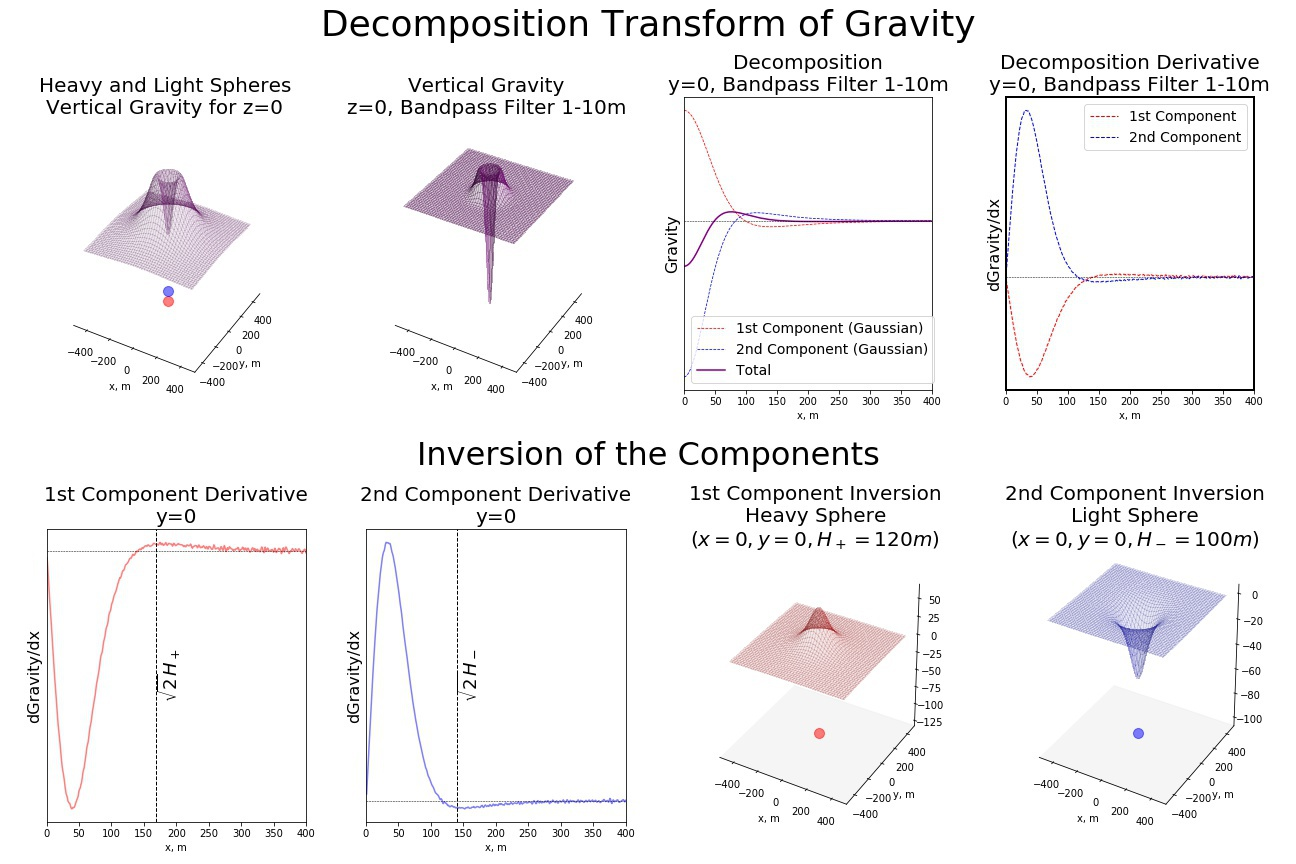

In [1]:
from IPython.display import Image
Image(filename='../Inversion of Gravity Mathematics/Spheres.jpg')

Workflow:

* generate synthetic density model
    (by defined set of 3D density points, where surface points are not physically correct),

* calculate forward gravity vertical component on surface from the density model,

* calculate Radon Transform (also known as Focal Average) and produce inversion model
    (we use fast simplified transform good enough for our demonstration),

* calculate Fractality Index and produce density-depth profile,

* calculate forward gravity on surface,

* compare original model and the inversion model density-depth profiles,

* compare forward gravity from the synthetic density model and the inversion density model.

See also more complex and realistic model:
[3D Synthetic Density Inversion by Circular Hough Transform [Focal Average]](3D%20Synthetic%20Density%20Inversion%20by%20Circular%20Hough%20Transform%20%5BFocal%20Average%5D.ipynb)

In [2]:
# install dependencies
import sys
!{sys.executable} -m pip install matplotlib pyvista xarray scipy distributed numba Pillow > /dev/null

In [3]:
# processing packages
import xarray as xr
import numpy as np
import pandas as pd
import math
# statistics packages
from scipy.signal import convolve2d
from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate, stats
# speed optimization packages
from numba import jit
from dask.distributed import Client
from dask.distributed import LocalCluster

In [4]:
# plotting modules
import pyvista as pv
# pyvista plots display
import PIL
import io
# magic trick for white background
pv.set_plot_theme("document")
pv.set_plot_theme("white")
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Define functions

In [5]:
# while this function is fast numpy-based one we still have 15-20% performance boost by numba 
# [мГал]
@jit(nopython=True, parallel=True)
def delta_grav_vertical(delta_mass, x, y, z):
    G=6.67408*1e-11
    return -np.sum((100.*1000)*G*delta_mass*z/np.power(x**2 + y**2 + z**2, 1.5))

@jit(nopython=True, parallel=True)
def gaussian(x, y, z, std, amplitude):
    r2 = x**2 + y**2 + z**2
    return amplitude*np.exp(-r2/std**2)

def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1,mode='constant', cval=0) \
            - gaussian_filter(raster.values,g2,mode='constant', cval=0)
    return raster

def spectrum(raster, gammas, dgamma = 1.0):
    rasters = []
    for g in gammas:
        print (g,". ", end = '')
        _raster = raster_filter_range(raster, g-dgamma/2, g+dgamma/2)
        rasters.append(_raster)
    return rasters

# define circular mask
def unit_circle_2d(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt( A[:,None] + A)
    if r <= 2:
        return ((dists-r)<=0).astype(int)
    return ((dists-r)<=0.5).astype(int)

# use vectorization and dask processing together
def forward_gravity(da):
    (da_y, da_x, da_z) = xr.broadcast(da.y, da.x, da.z)
    deltagrav = lambda x0, y0: delta_grav_vertical(da.values.ravel(), (da_x.values.ravel()-x0), (da_y.values.ravel()-y0), (da_z.values.ravel()-0))
    gravity = xr.apply_ufunc(deltagrav, da_x.isel(z=0).chunk(50), da_y.isel(z=0).chunk(50), vectorize=True, dask='parallelized')
    name = 'inv_gravity' if da.name[:3] == 'inv' else 'gravity'
    return gravity.rename(name)

# coordinates order 'x','y','z'
# point_data=True for Point data array and point_data=False for Cell data array
# Point data array required for isolines extraction
def da2UniformGrid(da, point_data=True):
    grid = pv.UniformGrid()
    grid.origin = (da.x.min(), da.y.min(), da.z.min())
    grid.spacing = (abs(da.x.diff(dim='x')[0]), abs(da.y.diff(dim='y')[0]), abs(da.z.diff(dim='z')[0]))
    values = da.transpose('x','y','z').reindex(z=da.z[::-1]).values.flatten(order="F")
    if point_data:
        grid.dimensions = da.shape
        grid.point_arrays[da.name] = values
    else:
        grid.dimensions = np.array(da.shape) + 1
        grid.cell_arrays[da.name] = values
    return grid

# coordinates order 'x','y'
def da2StructuredGrid(da):
    (da_y, da_x) = xr.broadcast(da.y, da.x)
    mesh = pv.StructuredGrid(da_x.values, da_y.values, da.values)
    mesh[da.name] = da.values.ravel(order="F")
    return mesh

## Modeling Parameters

In [6]:
std = 20
print (f'Model standard deviation: {std}')
depth = 50
print (f'Model depth: {depth}')
downscale = 4
print (f'Model reduce by factor: {downscale}')
# use empty array [] to disable modeling gravity Gaussian filtering
sigmas = []
#sigmas = [std/2,int(np.sqrt(2)*depth)]
print (f'Gaussian range filter for model gravity: {sigmas}')

L = 200
Z = 50
print (f'Model 3D grid: {L}x{L}x{Z}')
xsize = L/2
print (f'Model analysis area: {xsize}')

# define synthetic model density distribution on the grid
X0 = np.array([250,275,300,350,400,450,500,525,550])/2 - 200
Y0 = np.array(len(X0)*[0])
Z0 = np.array([50,0,50,25,0+50,25,50,0,50])/2
V0 = -np.array([-1,-1,1,-1,-1+0,-1,1,-1,-1])

Model standard deviation: 20
Model depth: 50
Model reduce by factor: 4
Gaussian range filter for model gravity: []
Model 3D grid: 200x200x50
Model analysis area: 100.0


In [7]:
# calculate maximum processing radius for define model Z
rmax = round(depth*np.sqrt(2))
print (f'Model radius on surface: {rmax}')
# make output basename
if sigmas == []:
    basename = f'basic1to{downscale}'
else:
    basename = f'basic1to{downscale}sigma{int(np.round(sigmas[0])):02d}to{int(np.round(sigmas[1])):02d}'
print (f'Output basename for plots and datafiles: {basename}')

Model radius on surface: 71
Output basename for plots and datafiles: basic1to4


## Setup local DASK cluster for multicore lazy processing

In [8]:
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:50925 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


## Synthetic Density Model

In [9]:
x = np.linspace(-L,L,2*L+1)
y = np.linspace(-L,L,2*L+1)
z = -np.arange(1,Z+1)
(xx,yy,zz) = np.meshgrid(x,y,z)

# produce synthetic density
density = xr.DataArray(np.zeros(zz.shape),
                          coords={'x': x, 'y': y, 'z': z},
                          dims=['y','x','z']).rename('density')
for (x0,y0,z0,v0) in zip(X0,Y0,Z0,V0):
    density.values += gaussian(xx+x0, yy+y0, zz+z0, std, v0)

## Reduce Synthetic Density Model
Note: this's a choice between processing accuracy vs calculation time

In [10]:
if downscale > 1:
    density = density.coarsen({'x':downscale, 'y':downscale, 'z':downscale}, boundary="trim")\
        .mean()\
        .rename(density.name)

## Gravity Forward Model of Synthetic Density

In [11]:
%%time
# complete lazy calculation
gravity = forward_gravity(density).load()

CPU times: user 2.63 s, sys: 308 ms, total: 2.94 s
Wall time: 29.5 s


In [12]:
# filter gravity
if sigmas != []:
    gravity = raster_filter_range(gravity, sigmas[0]/downscale, sigmas[1]/downscale)

In [13]:
# simple normalization (might produce biased estimation)
gravity = (gravity-gravity.mean())/gravity.std()

## Show Synthetic Density Model and Forward Gravity

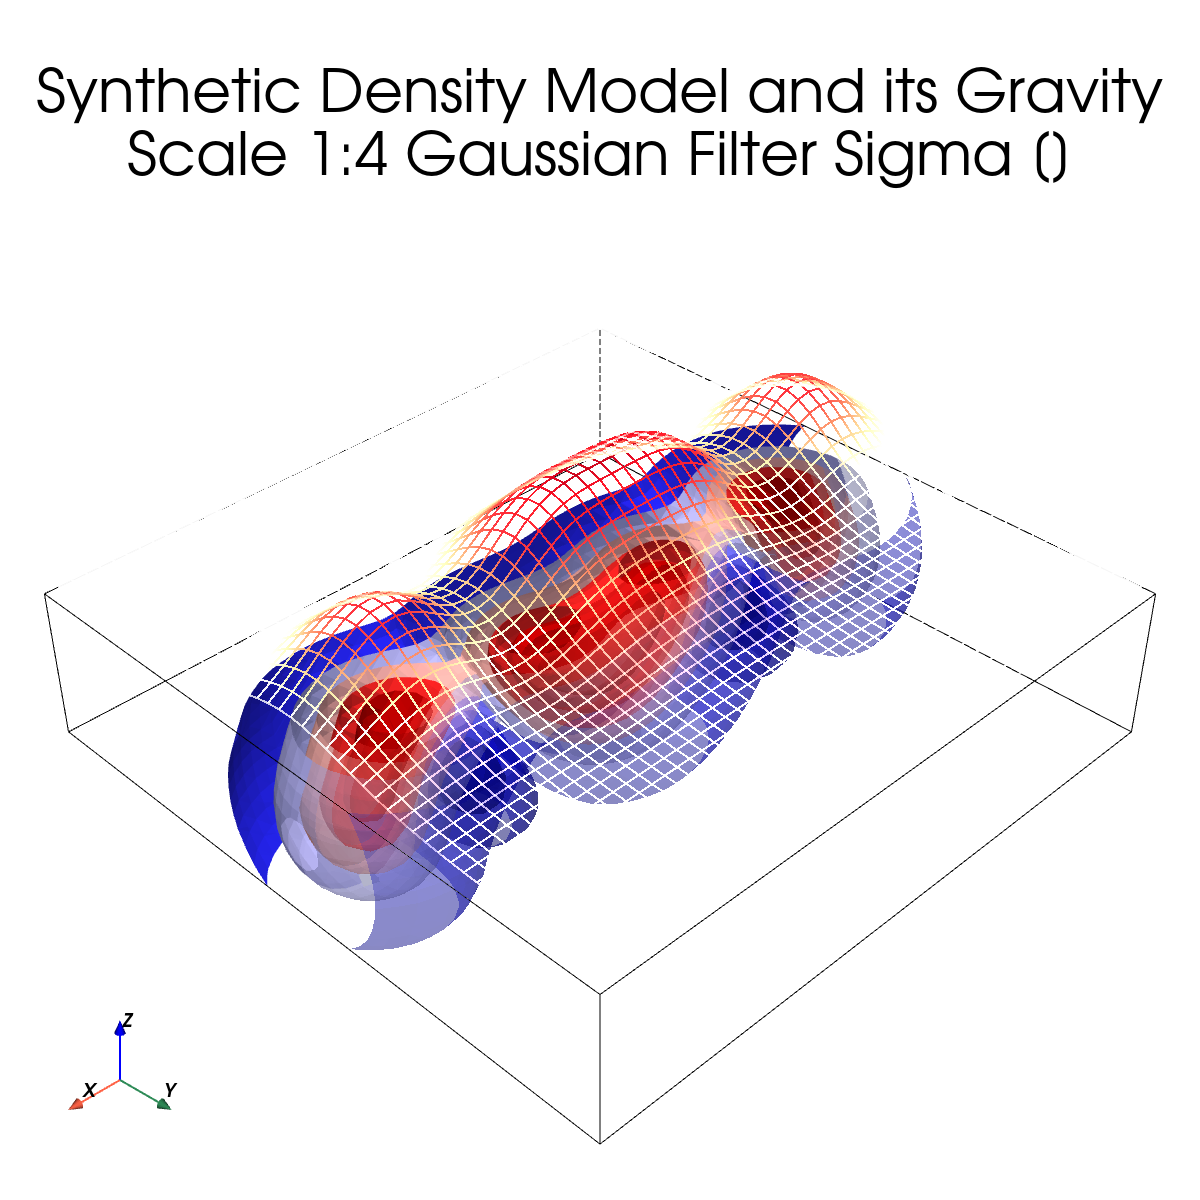

In [14]:
zscale = 5

p = pv.Plotter()

da = density.sel(x=slice(-xsize,xsize), y=slice(-xsize,xsize)).copy()
grid = da2UniformGrid(da)
p.add_mesh(grid.outline(), color="k")
contours = grid.contour(isosurfaces=10, scalars="density")
p.add_mesh(contours.clip(normal='y', invert=True), opacity=1, cmap='seismic', ambient=0.2, show_scalar_bar=False)
p.add_mesh(contours.clip(normal='y', invert=False), opacity=0.5, cmap='seismic', ambient=0.2, show_scalar_bar=False)

da = gravity.sel(x=slice(-xsize,xsize), y=slice(-xsize,xsize))
mesh = da2StructuredGrid(zscale*(1+da))
p.add_mesh(mesh, opacity=.8, cmap='Reds', style='wireframe', line_width=2, lighting=False, ambient=1, show_scalar_bar=False)

p.show_axes()
p.add_title(f'Synthetic Density Model and its Gravity\nScale 1:{downscale} Gaussian Filter Sigma {np.round(sigmas).astype(int)}', font_size=24)
p.screenshot(f'{basename}.model.jpg', window_size=(1200, 1200))
byteIO = io.BytesIO()
PIL.Image.fromarray(p.image).save(byteIO, format='PNG')
Image(data=byteIO.getvalue(), width=500)

## Fractal Dimension Index by Discrete Gravity Spectrum
Note: Fractal Dimension Index is proportional to average density per depth for the area

In [15]:
# discrete spectrum range
gammas = np.arange(1,int(rmax/downscale+0.5),1)
# real z coordinate
depth_fractal = -(gammas[1:] - 1/2)/np.sqrt(2)

In [16]:
%%time
# discrete dravity spectrum
grav_spectrum = spectrum(gravity, gammas, 1)
# limit work area to exclude border effects
grav_spectrum_stds = [_.sel(x=slice(-Z,Z),y=slice(-Z,Z)).std() for _ in grav_spectrum]
# power spectrum
grav_power_spectrum = xr.DataArray(grav_spectrum_stds,
                          coords={'z': downscale*gammas.astype('float32')},
                          dims=['z']).rename('spectrum')

1 . 2 . 3 . 4 . 5 . 6 . 7 . 8 . 9 . 10 . 11 . 12 . 13 . 14 . 15 . 16 . 17 . CPU times: user 116 ms, sys: 12.4 ms, total: 128 ms
Wall time: 127 ms


In [17]:
# calculate fractality index
slope = np.diff(np.log10(grav_spectrum_stds))/np.diff(np.log10(gammas))
fractal = (3 - (slope/2))

## Circular Hough Transform [Focal Average]
Note: simplified transform is easy but produces some issues (including misrepresented density-depth profile)

In [18]:
%%time
rs = np.arange(int(rmax/downscale+0.5))[1:]
means = []
for r in rs:
    print (r, end=' ')
    mask = unit_circle_2d(r)
    mask[1:-1,1:-1] -= unit_circle_2d(r-1)
    mean = convolve2d(gravity, mask/np.sum(mask), mode='same')
    means.append(mean)
means = np.array(means)
# make dataarray
dx = gravity.x.diff('x').values[0]
inv_density = xr.DataArray(means, coords=[-dx*rs/np.sqrt(2), gravity.x, gravity.y], dims=['z','y','x'])
# transpose to the same structure as synthetic [original] density
inv_density = inv_density.transpose('y','x','z').rename('inv_density')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 CPU times: user 259 ms, sys: 15.8 ms, total: 275 ms
Wall time: 287 ms


In [19]:
# simple normalization (might produce biased estimation)
inv_density = (inv_density-inv_density.mean())/inv_density.std()

## Gravity Forward Model of Inversion Density

In [20]:
%%time
# complete lazy calculation
inv_gravity = forward_gravity(inv_density).load()

CPU times: user 1.9 s, sys: 293 ms, total: 2.2 s
Wall time: 29.6 s


In [21]:
# simple normalization (might produce biased estimation)
inv_gravity = (inv_gravity-inv_gravity.mean())/inv_gravity.std()

## Show Inversion Density Model and Forward Gravity

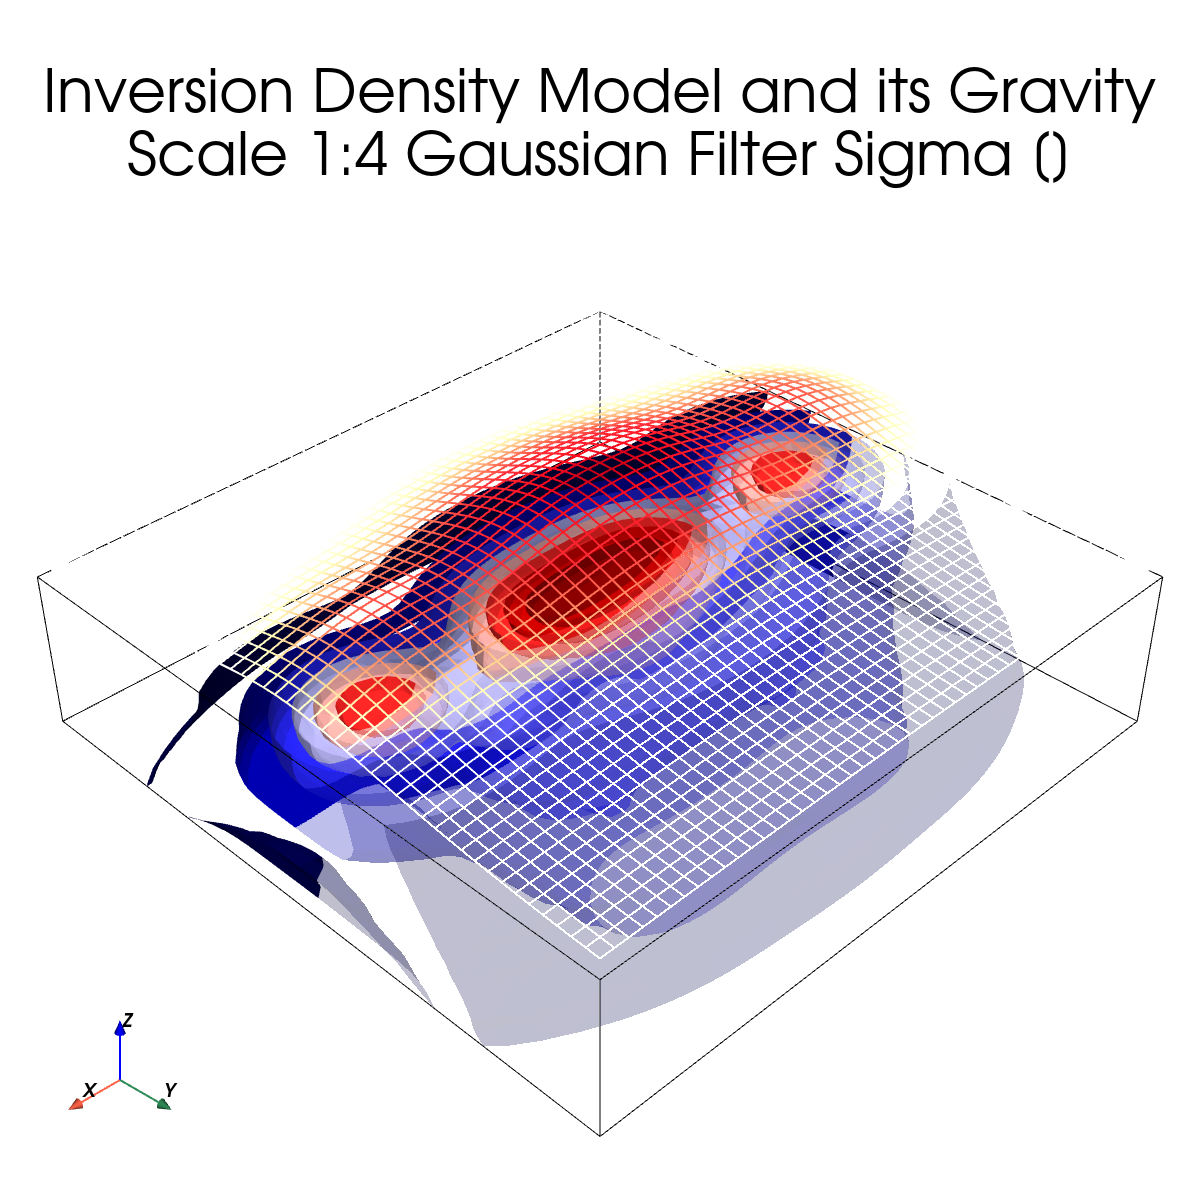

In [22]:
zscale = 5

p = pv.Plotter()

da = inv_density.sel(x=slice(-xsize,xsize), y=slice(-xsize,xsize)).copy()
grid = da2UniformGrid(da)
p.add_mesh(grid.outline(), color="k")
contours = grid.contour(isosurfaces=10, scalars="inv_density")
p.add_mesh(contours.clip(normal='y', invert=True), opacity=1, cmap='seismic', ambient=0.2, show_scalar_bar=False)
p.add_mesh(contours.clip(normal='y', invert=False), opacity=0.25, cmap='seismic', ambient=0.2, show_scalar_bar=False)

da = inv_gravity.sel(x=slice(-xsize,xsize), y=slice(-xsize,xsize))
mesh = da2StructuredGrid(zscale*(1+da))
p.add_mesh(mesh, opacity=1, cmap='Reds', style='wireframe', line_width=2, lighting=False, ambient=1, show_scalar_bar=False)

p.show_axes()
p.add_title(f'Inversion Density Model and its Gravity\n\
Scale 1:{downscale} Gaussian Filter Sigma {np.round(sigmas).astype(int)}', font_size=24)
p.screenshot(f'{basename}.inversion.jpg', window_size=(1200, 1200))
byteIO = io.BytesIO()
PIL.Image.fromarray(p.image).save(byteIO, format='PNG')
Image(data=byteIO.getvalue(), width=500)

## Model Accuracy Estimation by Density profiles
Calculate Pearson's correlation coefficient between the density profiles
Note: There is linear scale factor between the density profiles values

In [23]:
# extract inversion model density-depth profile
inverse = inv_density.sel(z=slice(0,-depth), x=slice(-xsize, xsize), y=slice(-xsize, xsize)).mean(['y','x'])
# extract original model density-depth profile
original = density.sel(z=slice(0,-depth), x=slice(-xsize, xsize), y=slice(-xsize, xsize)).mean(['y','x'])
# interpolate the original profile on the inversion model 'z' coordinate
f = interpolate.interp1d(original.z, original, fill_value='extrapolate')
original_regridded = f(inverse.z)
# interpolate the fractal index on the inversion model 'z' coordinate
f = interpolate.interp1d(depth_fractal, fractal, fill_value='extrapolate')
fractal_regridded = f(inverse.z)
# exclude depths between 0 and 11m due to boundary effects
df = pd.DataFrame({'orig':original_regridded, 'inv':inverse,'frac':fractal_regridded,'z':inverse.z})
df = df[df.z<-std/2]

### Visualize Synthetic, Inversion and Fractality Density

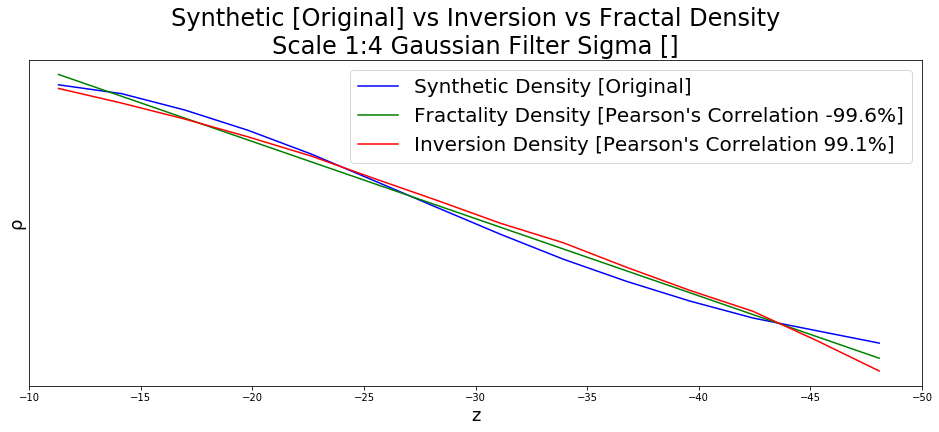

In [24]:
fig = plt.figure(figsize=(16,6))

plt.plot(df.z.values, df.orig.values, c='blue', label='Synthetic Density [Original]')

# calculate a linear least-squares regression between original and inversion density-depth profiles
inv_frac = stats.linregress(df.frac.values, df.orig.values)
# linearly scale the fractal index
frac_corr = np.round(100*inv_frac.rvalue,1)
plt.plot(df.z.values, inv_frac.intercept + inv_frac.slope*df.frac.values, 'g',
         label=f"Fractality Density [Pearson's Correlation {frac_corr}%]")
plt.title(f'Synthetic [Original] vs Inversion vs Fractal Density\n\
Scale 1:{downscale} Gaussian Filter Sigma {np.round(sigmas).astype(int)}', fontsize=24)

# calculate a linear least-squares regression between original and inversion density-depth profiles
inv_res = stats.linregress(df.inv.values, df.orig.values)
# linearly scale the inversion profile
inv_corr = np.round(100*inv_res.rvalue,1)
plt.plot(df.z.values, inv_res.intercept + inv_res.slope*df.inv.values, 'r',
         label=f"Inversion Density [Pearson's Correlation {inv_corr}%]")
plt.legend(fontsize=20)

plt.ylabel('ρ',fontsize=18)
plt.xlabel('z', fontsize=18)
plt.yticks([])
plt.xlim([-std/2,-depth])

plt.savefig(f'{basename}.corr.jpg', dpi=150, quality=95)
plt.show()

## Compare Gravity Forward Models of Synthetic [Original] and Inversion Density

In [25]:
def compare_grav(da1, da2, xsize):
    # crop work area to exclude border effects
    subset1 = da1.sel(x=slice(-xsize,xsize), y=slice(-xsize,xsize))
    subset2 = da2.sel(x=slice(-xsize,xsize), y=slice(-xsize,xsize))
    # simple normalization (might produce biased estimation)
    subset1 = (subset1-subset1.mean())/subset1.std()
    subset2 = (subset2-subset2.mean())/subset2.std()
    # correlation %
    corr = np.round(100*np.corrcoef(subset2.values.ravel(), subset1.values.ravel())[0,1],2)
    #corr, '%'
    # difference map with cropped histogram
    subset_delta = (subset1/subset2)
    q = [1,99]
    pcnt = np.nanpercentile(subset_delta.values.reshape(-1),q)
    subset_delta.values = np.clip(subset_delta.values,pcnt[0],pcnt[1])
    subset_delta = subset_delta - subset_delta.mean()
    
    return (subset1, subset2, subset_delta, corr)

In [26]:
(subset_gravity1, subset_inv_gravity1, subset_delta1, corr1) = compare_grav(gravity, inv_gravity, depth)
(subset_gravity2, subset_inv_gravity2, subset_delta2, corr2) = compare_grav(gravity, inv_gravity, 3*depth)

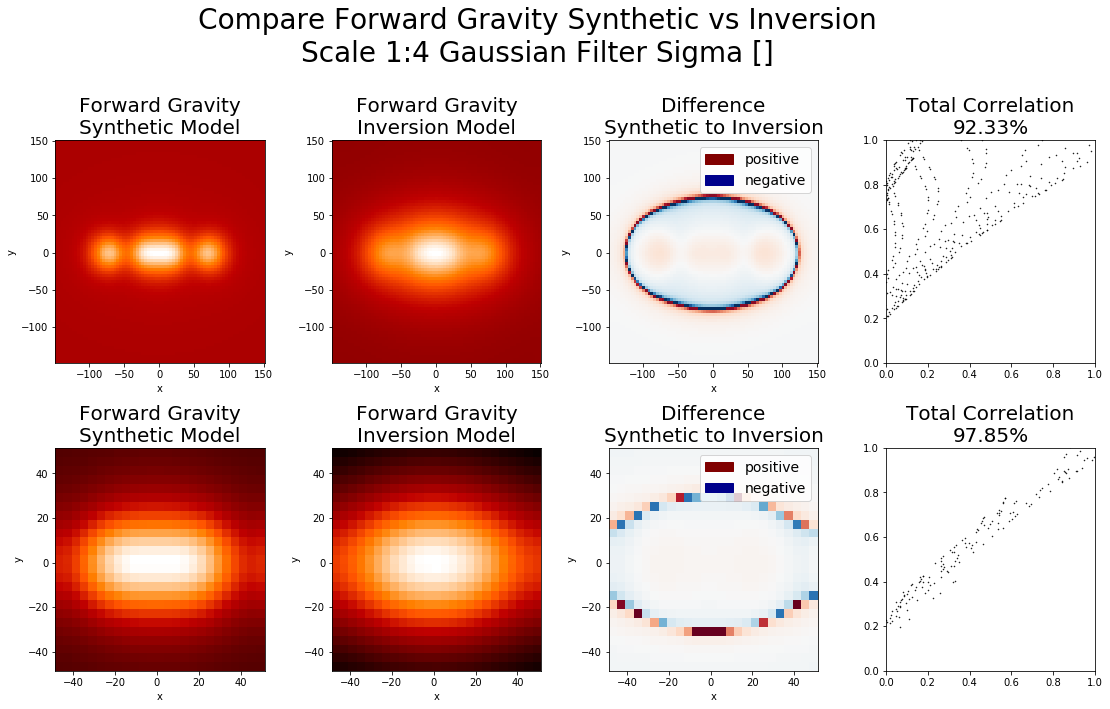

In [27]:
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(2, 4, 1)
subset_gravity2.plot(ax=ax, cmap='gist_heat', add_colorbar=False)
ax.set_title('Forward Gravity\nSynthetic Model', fontsize=20)

ax = fig.add_subplot(2, 4, 2)
subset_inv_gravity2.plot(ax=ax, cmap='gist_heat', add_colorbar=False)
ax.set_title('Forward Gravity\nInversion Model', fontsize=20)

ax = fig.add_subplot(2, 4, 3)
red_patch = mpatches.Patch(color='maroon', label='positive')
blue_patch = mpatches.Patch(color='darkblue', label='negative')
ax.legend(handles=[red_patch, blue_patch], fontsize=14)
subset_delta2.plot(ax=ax, add_colorbar=False)
ax.set_title(f'Difference\nSynthetic to Inversion', fontsize=20)

ax = fig.add_subplot(2, 4, 4)
ax.plot(subset_gravity2.values.reshape(-1),subset_inv_gravity2.values.reshape(-1), c='black',
       marker='.', linewidth=0, markersize=1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title(f'Total Correlation\n{corr2}%', fontsize=20)

ax = fig.add_subplot(2, 4, 5)
subset_gravity1.plot(ax=ax, cmap='gist_heat', add_colorbar=False)
ax.set_title('Forward Gravity\nSynthetic Model', fontsize=20)

ax = fig.add_subplot(2, 4, 6)
subset_inv_gravity1.plot(ax=ax, cmap='gist_heat', add_colorbar=False)
ax.set_title('Forward Gravity\nInversion Model', fontsize=20)

ax = fig.add_subplot(2, 4, 7)
red_patch = mpatches.Patch(color='maroon', label='positive')
blue_patch = mpatches.Patch(color='darkblue', label='negative')
ax.legend(handles=[red_patch, blue_patch], fontsize=14)
subset_delta1.plot(ax=ax, add_colorbar=False)
ax.set_title(f'Difference\nSynthetic to Inversion', fontsize=20)

ax = fig.add_subplot(2, 4, 8)
ax.plot(subset_gravity1.values.reshape(-1),subset_inv_gravity1.values.reshape(-1), c='black',
       marker='.', linewidth=0, markersize=1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title(f'Total Correlation\n{corr1}%', fontsize=20)

plt.suptitle(f'Compare Forward Gravity Synthetic vs Inversion\n\
Scale 1:{downscale} Gaussian Filter Sigma {np.round(sigmas).astype(int)}', fontsize=28)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.87])
plt.savefig(f'{basename}.compare.jpg', dpi=150, quality=95)
plt.show()

## Save Models to NetCDF file

## Merge output plots

In [28]:
!convert +append {basename}.model.jpg {basename}.inversion.jpg _{basename}.jpg
!convert -append -gravity center \
    _{basename}.jpg {basename}.compare.jpg {basename}.corr.jpg \
    {basename}.jpg
!rm -f {basename}.model.jpg {basename}.inversion.jpg _{basename}.jpg {basename}.compare.jpg {basename}.corr.jpg

See lots of real-world models on

**LinkedIn**: https://www.linkedin.com/in/alexey-pechnikov/

**GitHub**:   https://www.linkedin.com/in/alexey-pechnikov/

**YouTube**:  https://www.youtube.com/channel/UCSEeXKAn9f_bDiTjT6l87Lg